## Import necessary python modules

In [1]:
import os
import napari
import tifffile
import numpy as np
import matplotlib.pyplot as plt

import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack

from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel
from buildReferenceSpot import buildReferenceSpotFromImages
from runBigfishDetection import getSpotAndClusters, saveSpotsNPZ, reorderZstack, getSpotAndClusters_multi

In [2]:
from order_spot import * 

import sys 

sys.path.append('/media/raphael/data/works/notebooks/notebook_scripts_perso/full_pipeline_perso/')
from follow_cells import *

## Specify Input and Output folders, identifiers

In [3]:
homeFolder = '/media/raphael/data/works/20231220_C3_14_2h_ofON/bleach_correction/w_background/'
nameKey = 'C3.14_ON_01_w1SPI-488_s'

imsQ = '4'
cellNumber = '52'
nucleiStackForm = nameKey+imsQ+"_cell_"

pathToTimeSequenceFullView = homeFolder+nameKey+imsQ+'/*.tif'
cell_Crop_Folder = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeSequenceCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'


sequenceCell = imr(pathToTimeSequenceCell)
sequenceCell = sequenceCell
mipSequenceCell = np.max(sequenceCell, axis=1)
MaxTimePoint = sequenceCell.shape[0]

In [4]:
pathToTimeSequenceMask = homeFolder+nameKey+imsQ+'/mask_'+str(cellNumber)+'/*.tif'
mask = imr(pathToTimeSequenceMask)

mipSequenceMask= np.max(mask, axis=1)
mask.shape

(120, 36, 116, 116)

## Specify voxel and object size

In [5]:
voxelRadius = (700, 110, 110) # in nanometers
objectRadius = (700, 105, 105) # in nanometers

In [6]:
alpha = 0.5
beta = 2
gamma = 15

## Choose detection threshold

In [7]:
selectedThreshold = int(input("Enter your selected threshold: "))

Enter your selected threshold: 120


In [8]:
minFrame = int(input("Enter your min Frame: "))
#minFrame = minFrame 

Enter your min Frame: 1


In [9]:
maxFrame = int(input("Enter your max Frame: "))
maxFrame = maxFrame + 1 

Enter your max Frame: 120


### Compute list of threshold 

## Get a list of spots detected using the threshold specified in previous step

In [10]:
images=[]    
spots_list=[]

spot_radius_px = detection.get_object_radius_pixel(
    voxel_size_nm=voxelRadius, 
    object_radius_nm=objectRadius, 
    ndim=3)

for t in range(minFrame,maxFrame,1):

    path = os.path.join(cell_Crop_Folder, nucleiStackForm+str(cellNumber)+'_t'+str(f"{t:03}")+".tif")
    rna = stack.read_image(path)
    images.append(rna)

n=len(images)
print("Total number of images : "+str(n))

selectedThreshold_loop = selectedThreshold

for rna in images:
    try : 
        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)
    
        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)
    
        # thresholding
        threshold = detection.automated_threshold_setting(rna_log, mask)
        
        selectedThreshold_loop = (selectedThreshold_loop) #*((100+var_list[i])/100) 
        #print(selectedThreshold_loop)
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold_loop))
        spots_list.append(spots_)
    except IndexError as e: 
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
        spots_list.append(spots_)
        print('Done')
        break 

Total number of images : 120


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


## Remove spot outside of cell mask for building the reference spot 

In [11]:
def sort_spot_list_mask(spot_list,mipSequenceCell,mask,cellNumber):
    '''
    The goal of this function is to sort spot which are on the side of a cell to improve the computing of the reference spot
    spot_list : numpy array corresponding to a numpy array of spots through the whole movie
    mipSequenceCell : 2D projection of the movie
    '''

    test_cell = get_cells(mipSequenceCell,mask,int(cellNumber))
    res=[]
    i=0
    count=0
    for spot_frame in spot_list : 
        tmp=[]
        
        for spot in spot_frame: 
            
            z=spot[0]
            y=spot[1]
            x=spot[2]
            
            #test_cell = np.max(test_cell, axis=1)
            
          
            if test_cell[i][y][x]!=0 : 
                tmp.append(spot)
            else : 
                count=count+1
            
        # if there is no spots
        if len(tmp)==0:
            tmp=np.empty((0,3))
            res.append(tmp)
                    
        res.append(np.array(tmp))
        i=i+1
    
    
    print('eliminated spots :', count)
    return res

In [12]:
spots_list = sort_spot_list_mask(spots_list,mipSequenceCell,mipSequenceMask,cellNumber)

eliminated spots : 5


## Build reference spot

image list found!
Found 1190
Found 1190 spots, max intensity = 333


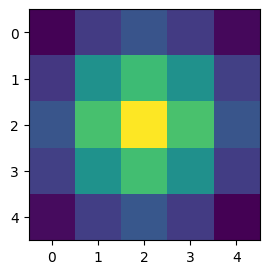

In [13]:
#gamma=5
reference_spot, _, _ = buildReferenceSpotFromImages(images, spots_list, alpha=alpha, gamma=5, voxelSize=voxelRadius, objectSize=objectRadius)
%matplotlib inline
plt.figure(num=3,figsize=(3,3))
plt.imshow(np.max(reference_spot, axis=0))
refSpot = deepcopy(reference_spot)

In [14]:
np.savez('/media/raphael/data/works/20231220_C3_14_2h_ofON/bleach_correction/expo/C3.14_ON_01_w1SPI-488_s4/refspot_18',reference_spot )

## Eliminate neighboor cells 

In [15]:
images = get_cells(images,mipSequenceMask,int(cellNumber))

## Perform spot and cluster detection for all frames

In [16]:
spotsFrame, clustersFrames, ThresholdFrames = getSpotAndClusters(images, 
                                                                 reference_spot, 
                                                                 cellnumber=cellNumber, 
                                                                 startTime=minFrame-1,
                                                                 stopTime=maxFrame-1,
                                                                 thresholdManual=selectedThreshold, 
                                                                 beta=beta, #2
                                                                 gamma=gamma, #15 
                                                                 numberOfSpots=2,
                                                                 radiusCluster=400, 
                                                                 voxelSize=voxelRadius, 
                                                                 objectSize=objectRadius,
                                                                 extensionMov='.tif')

0
1
2
3
4
5
6
7
8
9
10
11
12
13


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


50
51
52
53
54
55
56
57
58
59
60
61


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


/home/raphael/miniconda3/envs/bigfishlive/lib/python3.9/site-packages/bigfish/detection/spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


114
115
116
117
118
119
done!


In [17]:
a = sort_clustersFrames(clustersFrames,mipSequenceCell,400,perc=1)

on 26: max() arg is an empty sequence                                           
on 27: max() arg is an empty sequence                                           
on 28: max() arg is an empty sequence                                           
on 30: max() arg is an empty sequence                                           
on 31: max() arg is an empty sequence                                           
on 32: max() arg is an empty sequence                                           
on 34: max() arg is an empty sequence                                           
on 38: max() arg is an empty sequence                                           
on 39: max() arg is an empty sequence                                           
on 41: max() arg is an empty sequence                                           
on 44: max() arg is an empty sequence                                           
on 45: max() arg is an empty sequence                                           
on 46: max() arg is an empty

## Correct clusters position if needed 

In [32]:
a[15]

[array([17, 72, 86,  3,  0]), array([18, 73, 87,  3,  1])]

In [33]:
c[15]

[array([17, 72, 86,  6, 15])]

In [19]:
#a[2] = move_sorted_clustersFrames(a[2], np.array(a[2][1]), 0) #position 1 


## Merge clusters 

radius xy = 5
radius z = 2 


Reduire le radius et modifier la fonction pour adapter le rayon en fonction de la dimension 

In [20]:
b = merge_clusters_frame(a,mipSequenceCell,diffxy=5,diffz=1)

In [21]:
c = create_index(b)    

## Correct spots 

In [22]:
#spotsFrame = sort_spot_list(spotsFrame,mipSequenceMask,distance=2)

## Save detection results to be used later

In [23]:
saveSpotsNPZ(np.array(spotsFrame, dtype=object), 
             np.array(clustersFrames, dtype=object), 
             np.array(ThresholdFrames, dtype=object), 
             cellNumber, 
             cell_Crop_Folder, 
             reference_spot,
             threshold = selectedThreshold
             ) 


## Visualise detection results

In [26]:
def getDetectedPointsForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-1])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:]
    return pts_coords

def getDetectedClustersForFrame(pts_coordinates, frameNumer):
    sd = np.shape(pts_coordinates[frameNumer][:])
    pts_coords = np.empty([sd[0],sd[1]-3])
    for ii in range(np.shape(pts_coordinates[frameNumer][:])[0]):
        pts_coords[ii,:] = pts_coordinates[frameNumer][ii][1:3]
    return pts_coords

def set_pts_features(pts_layer, cls_layer, pts_coordinates, cluster_coordinate, step): #TxLayer
    # step is a 4D coordinate with the current slider position for each dim
    frameNumber = step[0]  # grab the leading ("time") coordinate
    pts_layer.data = getDetectedPointsForFrame(pts_coordinates,frameNumber)
    cls_layer.data = getDetectedClustersForFrame(cluster_coordinate,frameNumber)


pts_coordinates = spotsFrame
cluster_coordinate = a

viewer = napari.Viewer()
image_layer = viewer.add_image(
        mipSequenceCell, colormap='green' #maxImageCell
        )
if image_layer.data.ndim == 4:
    bigfishSpots = spotsFrame
elif image_layer.data.ndim == 3:
    bigfishSpots = getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2))
    
bigfish_Spots = viewer.add_points(
        getDetectedPointsForFrame(pts_coordinates,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=4,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='white',
        name = 'bigFish Detected Spots'
        )

bigfish_clusters = viewer.add_points(
        getDetectedClustersForFrame(cluster_coordinate,int(np.shape(mipSequenceCell)[0]/2)-1),
        face_color='#00000000',
        size=8,
        edge_width=0.3,
        edge_width_is_relative=False,
        edge_color='red',
        symbol='diamond',
        name = 'bigFish Clusters'
        )


viewer.dims.events.current_step.connect(
        lambda event: set_pts_features(bigfish_Spots, bigfish_clusters, pts_coordinates, cluster_coordinate, event.value)
        )



<function __main__.<lambda>(event)>

# Save clusters frame in csv 

In [25]:
save_csv_file(homeFolder,nameKey,imsQ,cellNumber,selectedThreshold,alpha,beta,gamma,c)

saved on  /media/raphael/data/works/20231220_C3_14_2h_ofON/bleach_correction/w_background/C3.14_ON_01_w1SPI-488_s4/2024_06_10_C3.14_ON_01_w1SPI-488_s4/C3.14_ON_01_w1SPI-488_s4_TS_cell_52_bleach_correction_sort_ref_spots0.5_2_15_thres_120.csv
